# Roget's Thesaurus (Data and Embeddings)

> Konstantinos Mpouros <br>
> Github: https://github.com/konstantinosmpouros <br>
> Year: 2024 <br>

## 1. About the notebook
---

The purpose of this notebook is to performe a part of the hole project (<b>Roget's Thesaurus in the 21st Century</b>) which is the data extraction and the embeddings creation. This Jupyter Notebook is dedicated to the extraction of textual data from [gutenberg's website](https://www.gutenberg.org/cache/epub/22/pg22-images.html) through web scraping techniques, followed by the generation of word embeddings for each word/phrase found within the scraped text. The notebook is divided into distinct sections, each focusing on a step of the whole process from data acquisition to preprocessing and finally, embedding generation. <br>

The models that were used to create the embeddings are the **Sentence Transformer**, the **Universal Sentence Encoder** and the **Gemma1.1-2B-it** and **Gemma1.1-7B-it**. All, are transformer model that are dedicaded to better understand phrases and sentences. These models are selected in order to see the difference between the quality of the embeddings that they produce while they have a significant difference in size. Although the results might be better if instead of words, as input for the models, we used small sentences that describe the meaning of the word.

> 1. **Sentence Transformer:** ST model is a lightweight transformer model designed to efficiently produce sentence embeddings. It is based on the MiniLM architecture, which stands for "Miniature Language Model", and is derived from a smaller variant of the BERT architecture. The model has about 22 million parameters. This includes both the weights and biases of the layers in the transformer model, and produces embeddings of 384 dimensions in size.
> 2. **Universal Sentence Encoder:** USE is a powerful transformer-based model designed for producing high-quality sentence embeddings. Developed by Google, this model leverages a transformer architecture tailored to efficiently capture the semantics of sentences. The USE model has approximately 512 million parameters, encompassing the weights and biases of its extensive layers. It outputs embeddings that are 512 dimensions in size, ensuring detailed and nuanced representation of the input sentences. This model is trained on diverse datasets, including web news, Wikipedia, and question-answer forums, which enable it to handle a wide variety of text inputs effectively. The USE is well-suited for tasks such as semantic similarity, clustering, and text classification, making it a versatile tool for natural language processing applications.
> 3. **Gemma:** The Gemma models are a state-of-the-art transformer-based language models designed for advanced natural language processing tasks. Developed by Google, these models features an extensive architecture with approximately 2.51 and 8.54 billion parameters, encompassing the weights across its numerous layers. The embeddings produced by the Gemma models typically have 2048 and 3072 dimensions each, providing a detailed and comprehensive representation of the input text.

## 2. Libraries
---

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Web Scraping
from bs4 import BeautifulSoup
import requests

# Vector DB
import faiss

# Pre-trained Embedding Models
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer

# Google's Gemma2
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# helper functions
import helper_functions as hf

2024-07-17 17:01:07.279874: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-17 17:01:07.463140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 17:01:07.463174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 17:01:07.493300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 17:01:07.557001: I tensorflow/core/platform/cpu_feature_guar

In [2]:
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

## 3. Data Extraction and Visualizations
---

### Data Extraction

In [3]:
url = 'https://www.gutenberg.org/cache/epub/22/pg22-images.html'
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

In [4]:
body = soup.find_all('div', class_='chapter')

classes = ''
division = np.nan
section = ''
category = np.nan
sub_category = ''
roget_words = list()

for chapter in body:
    # Extract the class and remove ([content], Number., \r, \n)
    classes = chapter.find('h2').extract().text.replace('\r\n', ' ')
    classes = str.strip(re.sub(r'\[.*?\]|\b\d+\.\s*', '', classes))
    
    # Iterate each tag of each chapter to capture the hierarchy and take the words accordingly.
    for tag in chapter:
    
        # Exctract the division if exists
        if tag.name == 'h2':
            division = tag.text
            division = re.sub(r'\[.*?\]|\b\d+\.\s*|\r|\n', '', division)
            division = str.strip(division)
    
        # Exctract the section
        elif tag.name == 'h3':
            # Exctract the section
            section = tag.text
            section = re.sub(r'\[.*?\]|\r\n|\d+\.\s*', '', section)
            section = str.strip(section)
    
            # Reset the category if we change section
            category = np.nan
    
        # Exctract the category if exists
        elif tag.name == 'h4':
            category = tag.text
            category = re.sub(r'\[.*?\]|\r\n|\d+\.\s*', '', category)
            category = str.strip(category).capitalize()
    
        # Extract the paragraph sub-category and the words with it
        elif tag.name == 'p' and 'p2' in tag.get('class', []):
            # Extract the paragraph's first letters to take the sub-category
            paragraph = str.strip(tag.text)
            sub_category = hf.clean_sub_categ(paragraph)
    
            # Clean paragraph step by step in order to extract the words
            paragraph = re.sub(r'[\{\(\[][^{}\(\)\[\]]*?[\}\)\]]|(\[\w+\s*\[\w+\]\])', '', paragraph)
            paragraph = re.sub(r'[\r\n]', ' ', paragraph)
            paragraph = re.sub(r'#.*?(N\.|—N\.|Adv\.|\.—)', '', paragraph, count=1)
            paragraph = re.sub(r'&c\.|[Aa]dj\.', ';', paragraph)
            paragraph = re.sub(r'\.\—N\.|—N\.|N\.|\.\—|[Vv]\.|[Aa]dj\.|[Aa]dv\.|&c\.|\{[^{}]*\}|\[[^\[\]]*\]|\([^()]*\)|\d+|Phr\.|"|\s+n\.|\|', '', paragraph)
    
            # Split the text and append each word with each categorization
            for word in re.split('[,;.]', paragraph):
                if len(str.strip(word)) > 1:
                    final_word = re.sub(r'\s+', ' ', str.strip(word)).replace('—', '')
                    roget_words.append([classes, division, section, category, sub_category, final_word])

roget_words = pd.DataFrame(roget_words, columns=['Class', 'Division', 'Section', 'Category', 'Sub-Category', 'Word'])
roget_words

,Class,Division,Section,Category,Sub-Category,Word
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,existence
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,being
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,entity
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,ens
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,esse
...,...,...,...,...,...,...
97140,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Temple,monastic
97141,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Temple,monasterial
97142,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Temple,conventual
97143,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Temple,ne vile fano


In [5]:
roget_words[roget_words['Word'].apply(len) < 2]

,Class,Division,Section,Category,Sub-Category,Word


In [6]:
roget_words[roget_words['Word'].apply(len) < 2]

,Class,Division,Section,Category,Sub-Category,Word


In [7]:
roget_words[roget_words.Word.isna() == True]

,Class,Division,Section,Category,Sub-Category,Word


In [8]:
roget_words[roget_words.Word == '']

,Class,Division,Section,Category,Sub-Category,Word


In [9]:
roget_words['Word'].nunique()

58880

In [10]:
roget_words[roget_words.duplicated()]

,Class,Division,Section,Category,Sub-Category,Word
145,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Inexistence,blank
217,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the concrete",Substantiality,bodily
301,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the concrete",Unsubstantiality,blank
481,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,Modal existence,State,trim
538,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,Modal existence,Circumstance,contingency
...,...,...,...,...,...,...
96739,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Clergy,priest
96740,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Clergy,high priest
96984,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Rite,lecture
96985,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Rite,ritual


In [11]:
roget_words[roget_words.Word == 'blank']

,Class,Division,Section,Category,Sub-Category,Word
104,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Inexistence,blank
145,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Inexistence,blank
268,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the concrete",Unsubstantiality,blank
301,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the concrete",Unsubstantiality,blank
12480,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION VIII. CAUSATION,Connection between cause and effect,Impotence,blank


In [12]:
roget_words.drop_duplicates(keep='first', inplace=True)
roget_words.shape

(94221, 6)

In [13]:
roget_words.reset_index(drop=True, inplace=True)

In [14]:
roget_words['Class'].nunique(), roget_words['Class'].unique()

(6,
 array(['CLASS I WORDS EXPRESSING ABSTRACT RELATIONS',
        'CLASS II WORDS RELATING TO SPACE',
        'CLASS III WORDS RELATING TO MATTER',
        'CLASS IV WORDS RELATING TO THE INTELLECTUAL FACULTIES',
        'CLASS V WORDS RELATING TO THE VOLUNTARY POWERS',
        'CLASS VI WORDS RELATING TO THE SENTIMENT AND MORAL POWERS'],
       dtype=object))

In [15]:
roget_words['Division'].nunique(), roget_words['Division'].unique()

(4,
 array([nan, 'DIVISION (I) FORMATION OF IDEAS',
        'DIVISION (II) COMMUNICATION OF IDEAS',
        'DIVISION (I) INDIVIDUAL VOLITION',
        'DIVISION (II) INTERSOCIAL VOLITION'], dtype=object))

In [16]:
roget_words['Section'].nunique(), roget_words['Section'].unique()

(39,
 array(['SECTION I. EXISTENCE', 'SECTION II. RELATION',
        'SECTION III. QUANTITY', 'SECTION IV. ORDER', 'SECTION V. NUMBER',
        'SECTION VI. TIME', 'SECTION VII. CHANGE',
        'SECTION VIII. CAUSATION', 'SECTION I. SPACE IN GENERAL',
        'SECTION II. DIMENSIONS', 'SECTION III. FORM',
        'SECTION IV. MOTION', 'SECTION I. MATTER IN GENERAL',
        'SECTION II. INORGANIC MATTER', 'SECTION III. ORGANIC MATTER',
        'SECTION I. OPERATIONS OF INTELLECT IN GENERAL',
        'SECTION II. PRECURSORY CONDITIONS AND OPERATIONS',
        'SECTION III. MATERIALS FOR REASONING',
        'SECTION IV. REASONING PROCESSES',
        'SECTION V. RESULTS OF REASONING',
        'SECTION VI. EXTENSION OF THOUGHT',
        'SECTION VII. CREATIVE THOUGHT',
        'SECTION I. NATURE OF IDEAS COMMUNICATED',
        'SECTION II. MODES OF COMMUNICATION',
        'SECTION III. MEANS OF COMMUNICATING IDEAS',
        'SECTION I. VOLITION IN GENERAL',
        'SECTION II. PROSPECTIV

In [17]:
roget_words['Category'].nunique(), roget_words['Category'].unique()

(90,
 array(['Being, in the abstract', 'Being, in the concrete',
        'Formal existence', 'Modal existence', 'Absolute relation',
        'Continuous relation', 'Partial relation', 'General relation',
        'Simple quantity', 'Comparative quantity',
        'Quantity by comparison with a standard',
        'Quantity by comparison with a similar object',
        'Changes in quantity', 'Conjunctive quantity', 'Concrete quantity',
        'Order in general', 'Consecutive order', 'Collective order',
        'Distributive order', 'Order as regards categories',
        'Number, in the abstract', 'Determinate number',
        'Indeterminate number', 'Absolute time', 'Relative time',
        'Recurrent time', 'Simple change', 'Complex change',
        'Constancy of sequence in events',
        'Connection between cause and effect', 'Power in operation',
        'Indirect power', 'Combinations of causes', 'Abstract space',
        'Relative space', 'Existence in space', 'General dimensions

In [18]:
roget_words['Sub-Category'].nunique()

1033

In [19]:
roget_words[roget_words['Sub-Category'] == '']

,Class,Division,Section,Category,Sub-Category,Word
32181,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,,#a
32182,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,,Insulation
32183,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,,Fire extinction
32184,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,,insulation
32185,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,,incombustible material
...,...,...,...,...,...,...
32253,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,,incombustible
32254,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,,nonflammable
32255,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,,uninflammable
32256,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,,unflammable


In [20]:
roget_words.iloc[32171 : 32190]

,Class,Division,Section,Category,Sub-Category,Word
32171,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,Fuel,vesta
32172,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,Fuel,fusee
32173,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,Fuel,locofoco
32174,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,Fuel,linstock
32175,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,Fuel,candle
32176,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,Fuel,carbonaceous
32177,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,Fuel,inflammable
32178,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,Fuel,high octane
32179,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,Fuel,high specific impulse
32180,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,Fuel,heat of combustion


In [21]:
roget_words.loc[32181:32257, 'Sub-Category'] = 'Insulation, fire extinction'
roget_words.drop(index=[32181, 32182, 32183], inplace=True)
roget_words.reset_index(drop=True, inplace=True)

roget_words[roget_words['Sub-Category'] == 'Insulation, fire extinction']

,Class,Division,Section,Category,Sub-Category,Word
32181,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,"Insulation, fire extinction",insulation
32182,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,"Insulation, fire extinction",incombustible material
32183,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,"Insulation, fire extinction",noncombustible material
32184,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,"Insulation, fire extinction",fire retardant
32185,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,"Insulation, fire extinction",flame retardant
...,...,...,...,...,...,...
32250,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,"Insulation, fire extinction",incombustible
32251,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,"Insulation, fire extinction",nonflammable
32252,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,"Insulation, fire extinction",uninflammable
32253,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,Sensation,"Insulation, fire extinction",unflammable


In [22]:
roget_words = roget_words[~roget_words['Word'].isin(['&', '&c', 'adv.', 'adv', '&c.'])]
roget_words.reset_index(drop=True, inplace=True)

In [23]:
roget_words

,Class,Division,Section,Category,Sub-Category,Word
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,existence
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,being
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,entity
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,ens
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,esse
...,...,...,...,...,...,...
94209,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Temple,monastic
94210,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Temple,monasterial
94211,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Temple,conventual
94212,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Temple,ne vile fano


In [24]:
roget_words['Final_Words'] = roget_words['Sub-Category'].astype(str) + ', ' + roget_words['Word'].astype(str)
roget_words

/tmp/ipykernel_27822/2947171780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roget_words['Final_Words'] = roget_words['Sub-Category'].astype(str) + ', ' + roget_words['Word'].astype(str)


,Class,Division,Section,Category,Sub-Category,Word,Final_Words
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,existence,"Existence, existence"
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,being,"Existence, being"
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,entity,"Existence, entity"
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,ens,"Existence, ens"
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"Being, in the abstract",Existence,esse,"Existence, esse"
...,...,...,...,...,...,...,...
94209,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Temple,monastic,"Temple, monastic"
94210,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Temple,monasterial,"Temple, monasterial"
94211,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Temple,conventual,"Temple, conventual"
94212,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,DIVISION (II) INTERSOCIAL VOLITION,SECTION V. RELIGIOUS AFFECTIONS,Religious institutions,Temple,ne vile fano,"Temple, ne vile fano"


In [25]:
roget_words.to_csv("Dataset/Roget's_Words.csv", index=False)

### Data Visualizations

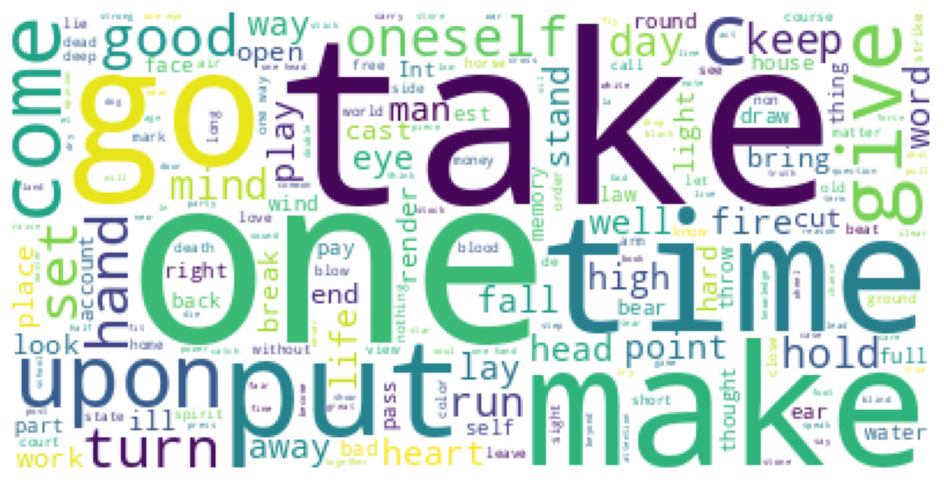

In [26]:
plt.figure(figsize=(15, 6))

all_words =  ' '.join(word for word in roget_words['Word'])
wordcloud = WordCloud(background_color='white',
                              repeat=True,
                              contour_color='black',
                              contour_width=.5,
                              min_font_size=2,
                             )

wordcloud.generate(all_words)
plt.imshow(wordcloud)
plt.axis('off')

plt.show()

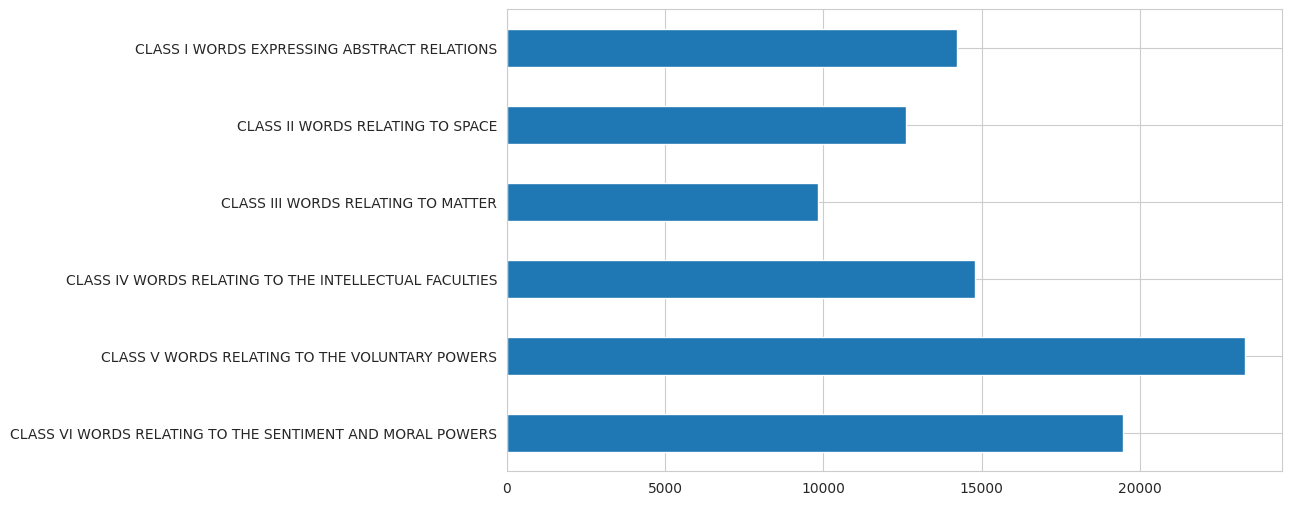

In [27]:
plt.figure(figsize=(10, 6))
roget_words['Class'].value_counts().sort_index(ascending=False).plot(kind='barh')
plt.ylabel(None)

plt.show()

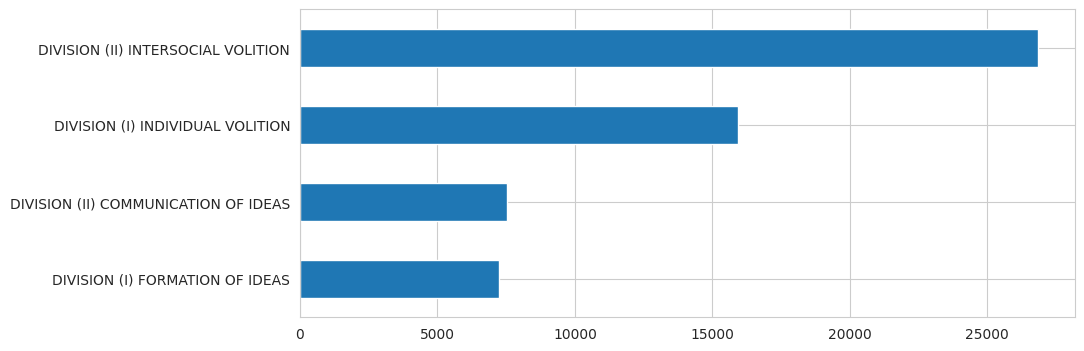

In [28]:
plt.figure(figsize=(10, 4))
roget_words['Division'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.ylabel(None)

plt.show()

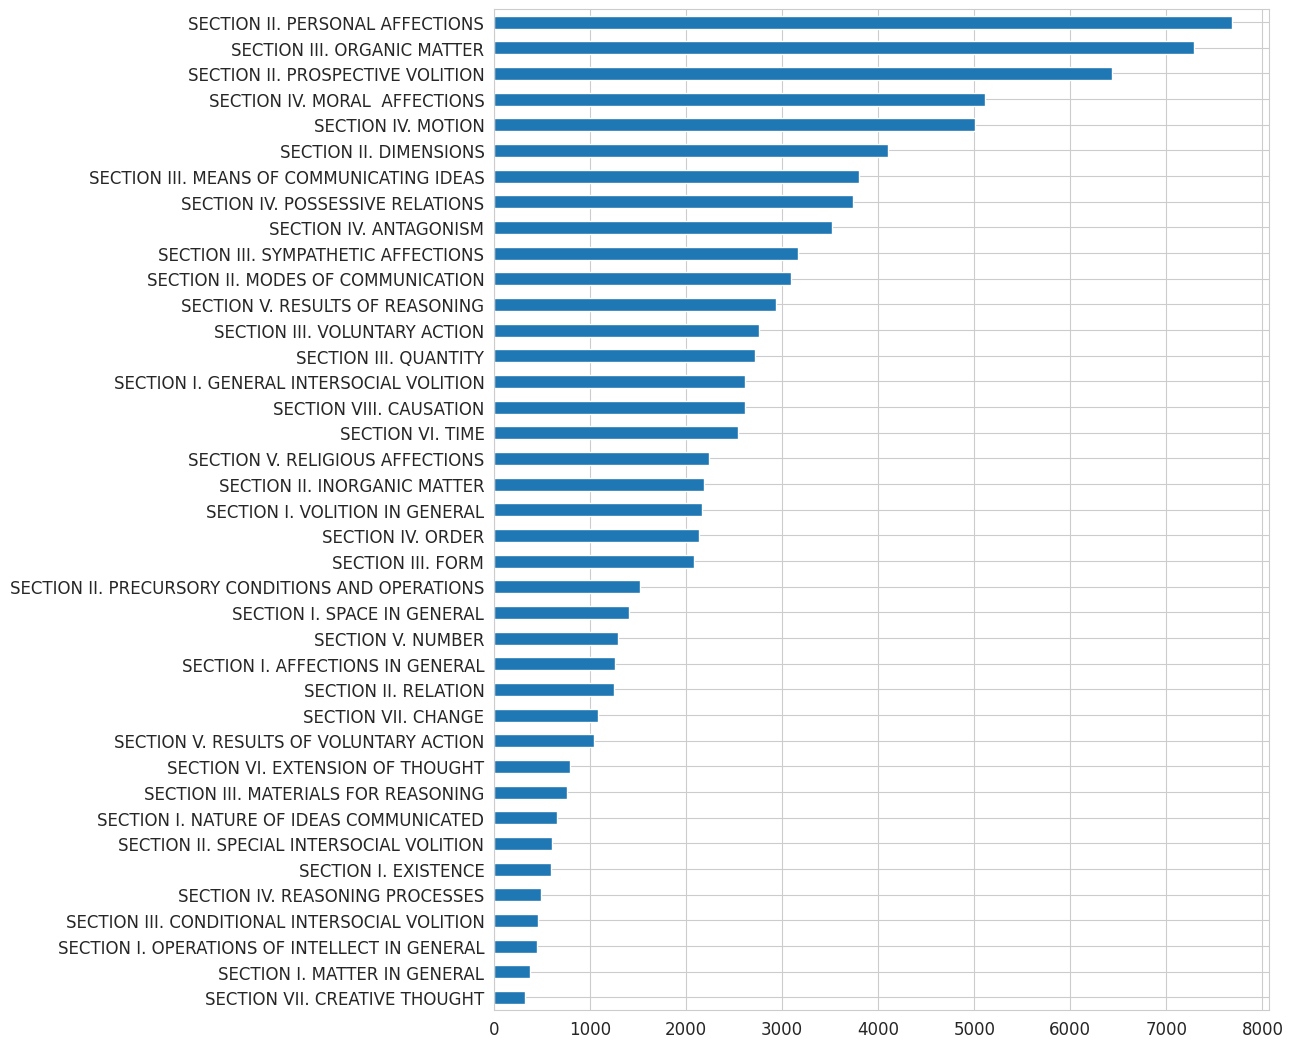

In [29]:
plt.figure(figsize=(10, 13))
roget_words['Section'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.ylabel(None)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

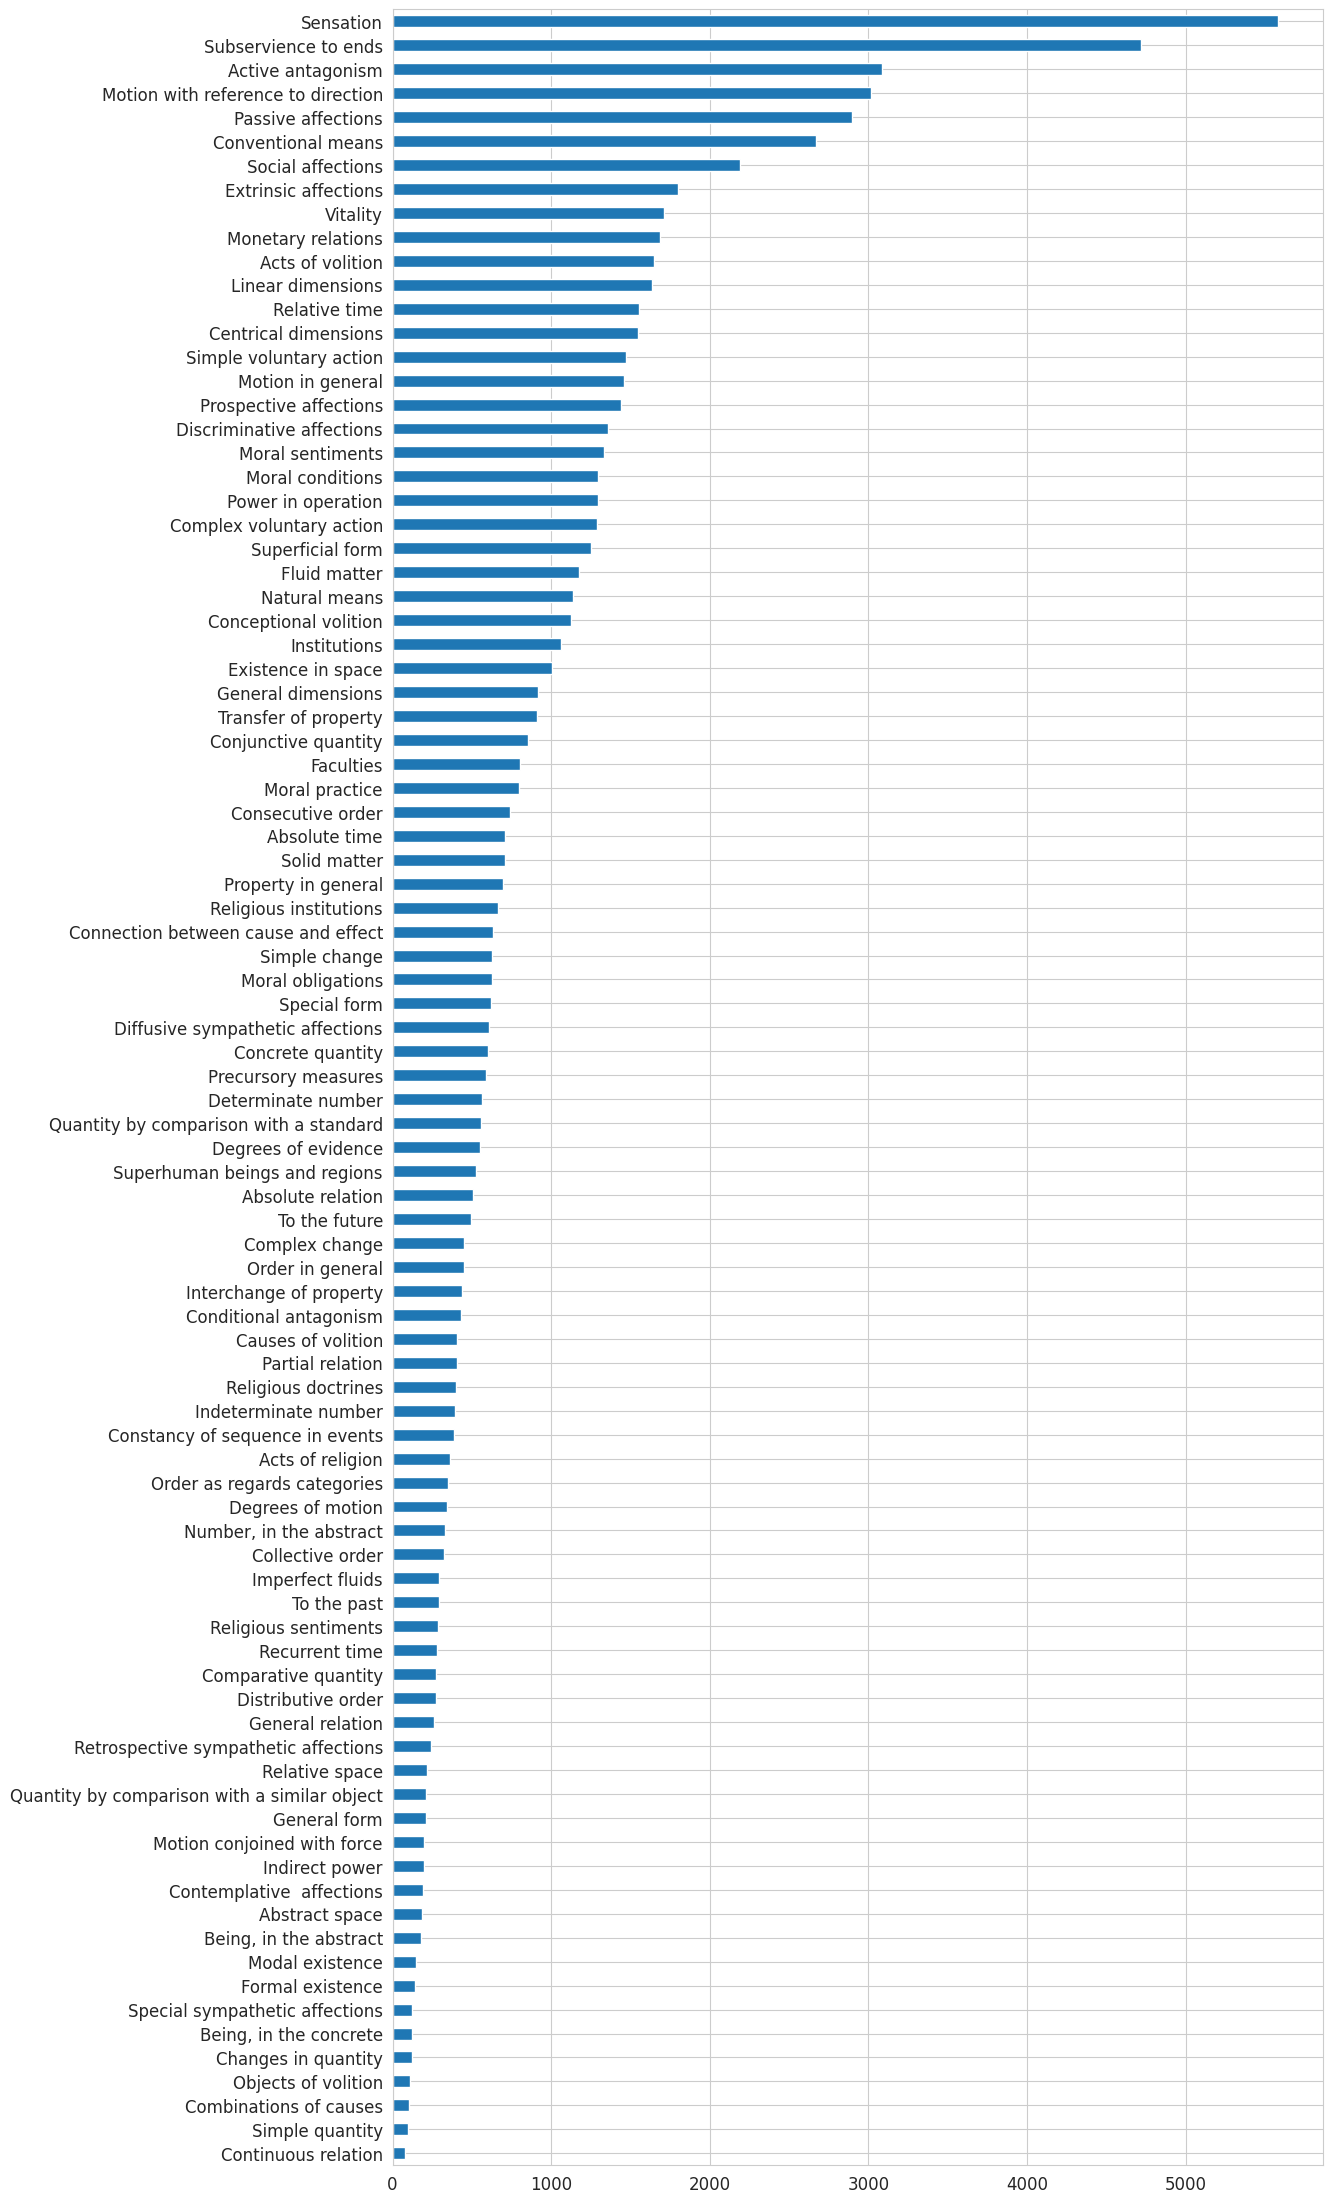

In [30]:
plt.figure(figsize=(12, 28))
roget_words['Category'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.ylabel(None)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## 4. Roget's Words Embeddings
---

### Sentence Transformers

In [32]:
# Load the pre-trained model
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [43]:
# Generate embeddings
sentence_tranformer_embeddings = sentence_transformer.encode(roget_words['Word'])

In [44]:
# Embeddings number match the number of the words so nothing was left behind
len(sentence_tranformer_embeddings), len(roget_words['Final_Words'])

(94214, 94214)

> the embeddings that we generated have 384 dimensions

In [45]:
len(sentence_tranformer_embeddings[0]), sentence_tranformer_embeddings[0]

(384,
 array([-6.88088164e-02,  1.55756774e-03, -6.29943609e-02,  3.74078713e-02,
        -4.55042906e-02,  5.26713915e-02,  7.77646154e-02, -3.93479429e-02,
         5.62467203e-02, -1.42512685e-02,  8.08919072e-02, -2.26019230e-02,
         4.83770110e-02,  4.58012242e-03, -2.98787490e-04, -1.23144565e-02,
         2.97384486e-02, -1.40542924e-01, -5.67162335e-02, -3.01477965e-02,
        -1.84678696e-02, -1.94176584e-02, -5.83643243e-02,  5.72983921e-02,
        -5.80368675e-02,  6.67893216e-02,  1.90744046e-02,  3.61803477e-03,
         5.28539792e-02, -6.97543100e-02,  4.56809346e-03,  1.30920773e-02,
         2.33698580e-02, -2.66002100e-02,  8.31490904e-02,  6.35661334e-02,
         4.94408049e-02, -3.30641232e-02, -1.83385573e-02, -6.20431975e-02,
        -7.77266696e-02, -5.32191284e-02,  2.67561525e-02, -5.71331680e-02,
         5.26199164e-03,  3.00013484e-03,  4.67874222e-02,  4.86986488e-02,
         4.02051434e-02, -4.59005199e-02, -1.34900749e-01,  1.48216169e-03,
      

> Save the embeddings of the sentence transformer in a vectordb that we can access it again from the other notebooks

In [60]:
sentence_tranformer_embeddings = pd.DataFrame(sentence_tranformer_embeddings)
sentence_tranformer_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383
0,-0.068809,0.001558,-0.062994,0.037408,-0.045504,0.052671,0.077765,-0.039348,0.056247,-0.014251,0.080892,-0.022602,0.048377,0.004580,-0.000299,-0.012314,0.029738,-0.140543,-0.056716,-0.030148,-0.018468,-0.019418,-0.058364,0.057298,-0.058037,0.066789,0.019074,0.003618,0.052854,-0.069754,0.004568,0.013092,0.023370,-0.026600,0.083149,0.063566,0.049441,-0.033064,-0.018339,-0.062043,-0.077727,-0.053219,0.026756,-0.057133,0.005262,0.003000,0.046787,0.048699,0.040205,-0.045901,-0.134901,0.001482,-0.028336,-0.050221,0.067421,0.022535,-0.051421,-0.012446,-0.056660,-0.078612,0.070950,0.046783,0.057713,0.000653,0.106963,0.040604,-0.021293,0.006505,0.018613,0.046656,0.007901,0.063662,-0.065995,0.148599,0.012671,-0.028885,0.040501,0.006821,0.113979,0.062266,0.046912,-0.021594,-0.039026,0.073965,-0.065847,0.022636,0.024963,-0.006625,0.008831,-0.036114,-0.067319,0.039428,-0.054205,-0.053317,-0.018314,-0.031476,-0.006954,-0.006160,0.034408,0.180843,-0.031280,0.006901,-0.010093,0.026268,0.014720,0.001826,-0.041734,-0.019852,0.033370,0.058935,0.027267,-0.062669,-0.011211,0.007653,0.084635,-0.044358,0.070065,-0.017433,-0.098449,-0.036522,0.056138,0.024429,0.060610,-0.029085,-0.047553,-0.095563,0.036726,-5.799197e-33,-0.002582,-0.079525,0.041136,0.018167,0.016084,0.028876,-0.051941,-0.012214,-0.007160,-0.024503,-0.026772,0.015718,-0.001179,0.006669,0.093914,-0.028606,0.073648,-0.061811,0.045561,-0.009788,-0.037317,-0.055492,-0.018285,-0.070844,-0.002597,0.037771,0.019056,-0.059326,0.008130,-0.035872,0.004694,-0.004309,-0.082909,0.033117,-0.037200,0.018273,-0.034502,0.004289,0.033383,-0.044888,0.000807,0.025390,-0.024572,-0.017472,0.069267,0.066337,0.110098,0.037589,-0.014777,0.012175,-0.026069,0.015783,-0.062266,-0.012706,0.020655,-0.030646,-0.061672,0.091136,0.054172,0.011150,0.030385,-0.046348,-0.056108,0.077843,-0.005315,-0.046203,0.014456,-0.116731,0.027290,-0.055230,-0.010915,-0.049569,-0.070040,0.004003,0.017087,-0.044076,0.024139,0.013700,-0.054763,0.004513,-0.010186,-0.128447,0.017101,0.025819,0.081804,0.002355,0.023749,-0.149567,-0.045709,0.070693,-0.056458,0.017068,0.015133,-0.043374,0.040466,3.055924e-33,0.039028,-0.007581,-0.048542,0.035124,-0.015633,0.013198,-0.044113,0.003740,-0.091739,-0.001847,0.021280,-0.019951,0.109942,0.002181,-0.052623,0.052122,0.020305,-0.035129,0.013174,0.078316,-0.006915,-0.020258,-0.040175,-0.005588,-0.044013,0.107465,0.059643,-0.065412,-0.111836,-0.008720,0.038103,0.002770,-0.045980,-0.001233,-0.028175,0.017001,0.035135,0.053108,-0.028721,0.003683,0.004410,0.014322,-0.007741,0.072256,-0.046304,-0.031639,0

In [54]:
d = sentence_tranformer_embeddings.shape[1]
d

384

In [55]:
# Initialize a FAISS index
index = faiss.IndexFlatL2(d)

In [57]:
index.add(sentence_tranformer_embeddings.values.astype('float32'))

In [59]:
faiss.write_index(index, 'Embeddings/ST_vectordb.faiss')

### Universal Sentence Encoder

In [62]:
# Loading the Universal Sentence Encoder model
module_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2"
model = hub.load(module_url)

2024-07-17 11:39:12.861509: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-17 11:39:12.866120: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-17 11:39:12.866153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-17 11:39:12.867514: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-17 11:39:12.867551: I external/local_xla/xla/stream_executor

In [63]:
# Generate embeddings
use_embeddings = model(roget_words['Final_Words'])

> We have the same number of embeddings as the words and each embeddings have 512 dimensions

In [64]:
len(use_embeddings), len(use_embeddings[0]), use_embeddings[0].numpy()

(94214,
 512,
 array([ 7.12820096e-03, -5.99268600e-02, -2.07134429e-02,  2.54848804e-02,
         4.72608991e-02,  2.02303063e-02, -2.30300669e-02,  3.81115377e-02,
         5.86297363e-02, -3.78727354e-02,  2.57817619e-02,  2.62149312e-02,
         6.73047677e-02,  7.33810151e-03,  2.56031249e-02, -8.57534558e-02,
        -5.74385524e-02,  6.47052824e-02, -2.26124320e-02, -2.34968904e-02,
         6.50841696e-03,  5.36170676e-02,  8.43264312e-02,  8.50311220e-02,
         1.88695211e-02,  4.15950008e-02,  7.72279799e-02, -2.81917639e-02,
        -2.62273457e-02, -1.43196899e-02,  8.10258240e-02, -6.49185851e-02,
         3.49870250e-02, -5.53703494e-02, -3.86004942e-03,  3.24178464e-03,
        -2.91115716e-02, -5.18916324e-02,  5.15279546e-02,  3.87697630e-02,
        -5.22455201e-02, -5.17305396e-02,  5.03047928e-02, -7.17199966e-02,
         2.88442755e-03, -5.46101071e-02, -5.58063760e-02,  1.73516162e-02,
         3.99209410e-02, -1.40277529e-02,  5.53470068e-02,  3.50585878e-02

> Save the embeddings in a vectordb

In [65]:
use_embeddings = pd.DataFrame(use_embeddings)
use_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.007128,-0.059927,-0.020713,0.025485,0.047261,0.020230,-0.023030,0.038112,0.058630,-0.037873,0.025782,0.026215,0.067305,0.007338,0.025603,-0.085753,-0.057439,0.064705,-0.022612,-0.023497,0.006508,0.053617,0.084326,0.085031,0.018870,0.041595,0.077228,-0.028192,-0.026227,-0.014320,0.081026,-0.064919,0.034987,-0.055370,-0.003860,0.003242,-0.029112,-0.051892,0.051528,0.038770,-0.052246,-0.051731,0.050305,-0.071720,0.002884,-0.054610,-0.055806,0.017352,0.039921,-0.014028,0.055347,0.035059,-0.007277,0.024844,-0.003671,-0.059494,0.022263,-0.004920,0.039559,0.004475,-0.023457,-0.039175,0.053461,-0.014152,0.001184,-0.056489,0.049535,-0.059582,0.046644,0.004350,-0.085227,-0.053116,0.057167,-0.061379,-0.058111,0.058998,0.014950,-0.042651,0.047854,-0.006346,0.003122,0.032291,-0.071742,0.051169,-0.037883,-0.017959,-0.013547,-0.028859,-0.011825,-0.071260,0.054181,-0.050573,-0.038112,0.018552,-0.043596,-0.051420,0.038493,0.038488,0.084041,0.042784,0.027273,-0.075187,-0.057538,0.053694,-0.067456,0.074294,-0.026369,0.028997,-0.068582,-0.043685,-0.060103,0.049187,-0.055147,0.025338,0.046666,0.029907,0.021004,0.011820,-0.042599,0.076022,-0.051175,0.057097,-0.049233,-0.007878,-0.074801,0.031483,-0.054143,-0.083639,0.050001,0.011956,-0.070813,0.067783,-0.004839,-0.033050,-0.042441,-0.038702,0.068191,0.006276,0.033435,0.044289,-0.049509,0.006111,0.042186,-0.057955,0.064499,-0.066640,-0.036356,-0.002668,-0.001494,0.027257,-0.012076,-0.064540,-0.029737,0.009674,0.032667,0.060594,0.012304,-0.032800,-0.020853,0.000836,0.035843,0.022261,0.031724,-0.069468,-0.032153,-0.006602,-0.004391,-0.064825,-0.061851,-0.078443,-0.030814,0.001470,0.029507,-0.007252,0.024842,-0.011081,0.063609,0.011167,0.071711,-0.021096,0.020911,0.057070,-0.010203,-0.026409,-0.085158,0.050956,0.045716,0.048851,0.033330,-0.036879,0.013631,0.047072,0.062855,0.018008,0.048515,-0.048691,0.026824,0.074964,0.050540,-0.008109,-0.029825,-0.012359,-0.025023,0.020036,0.022764,-0.027244,0.074068,0.072180,-0.072032,-0.032051,0.018241,0.001927,-0.047502,-0.057424,-0.066280,0.012940,-0.013316,

In [66]:
d = use_embeddings.shape[1]
d

512

In [67]:
index = faiss.IndexFlatL2(d)

In [68]:
index.add(use_embeddings.values.astype('float32'))

In [69]:
faiss.write_index(index, "Embeddings/USE_vectordb.faiss")

### Gemma 1.1 2B

In [31]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-1.1-2b-it")
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-1.1-2b-it",
    device_map='auto',
    torch_dtype=torch.bfloat16
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [32]:
model.eval()

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
try:
    model.to(device)
except Exception as ex:
    print(ex.args)

In [34]:
# input_text = "Create me one sentence with the meaning of the following: Existance"
# input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

# outputs = model.generate(**input_ids, max_new_tokens=40)
# print(tokenizer.decode(outputs[0]))

* Tokenize the words with the sub category together

In [36]:
batch_size = 50
word_embeddings  = []

for start in tqdm(range(0, len(roget_words), batch_size)):
    # Extract words
    end = start + batch_size
    words = roget_words['Final_Words'][start:end].tolist()
    
    batch_tokenized  = tokenizer(words,
                                 truncation=True,
                                 padding='max_length',
                                 max_length=20,
                                 return_tensors='pt').to('cuda')

    with torch.no_grad():
        outputs = model(**batch_tokenized, output_hidden_states=True)

    last_hidden_states = outputs.hidden_states[-1]
    batch_word_embedding  = last_hidden_states.mean(dim=1)

    for embedding in batch_word_embedding:
        word_embeddings.append(embedding.to('cpu').to(torch.float32).numpy())

100%|███████████████████████████████████████████████████████████████████████████████| 1885/1885 [07:25<00:00,  4.24it/s]


In [37]:
len(word_embeddings), len(word_embeddings[0]), word_embeddings[0]

(94214,
 2048,
 array([-0.08398438,  0.38476562,  0.45117188, ...,  1.5078125 ,
        -1.2421875 ,  1.0546875 ], dtype=float32))

In [38]:
word_embeddings = pd.DataFrame(word_embeddings)
word_embeddings.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [39]:
d = word_embeddings.shape[1]
d

2048

In [40]:
index = faiss.IndexFlatL2(d)

In [41]:
index.add(np.ascontiguousarray(word_embeddings.values.astype('float32')))

In [42]:
faiss.write_index(index, "Embeddings/Gemma1.1_2B_vectordb.faiss")

In [43]:
# batch_size = 10
# word_embeddings  = []
# errors = []

# for start in tqdm(range(0, len(roget_words), batch_size)):
#     # Extract words
#     end = start + batch_size
#     words = roget_words['Word'][start:end].tolist()

#     for indx, word in enumerate(words):
#         try:
#             # Tokenize the texts
#             tokenized_word = tokenizer(word, return_tensors='pt').to('cuda')
            
#             # Forward pass to get hidden states
#             with torch.no_grad():
#                 outputs = model(**tokenized_word, output_hidden_states=True)
            
#             # Extract hidden states of the last layer
#             last_hidden_states = outputs.hidden_states[-1]
            
#             word_embedding  = last_hidden_states.mean(dim=1)
#             word_embeddings.extend(word_embedding)
#         except Exception as ex:
#             error_indx = start + indx
#             print(ex.args)
#             print(f'Error in the word: {word} with index: {error_indx}')
#             errors.append(error_indx)

### Gemma 1.1 7B

In [31]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-1.1-7b-it")
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-1.1-7b-it",
    device_map='auto',
    torch_dtype=torch.bfloat16
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device device because they were offloaded to the cpu.


In [32]:
model.eval()

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): Gemm

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
try:
    model.to(device)
except Exception as ex:
    print(ex.args)

You shouldn't move a model that is dispatched using accelerate hooks.


("You can't move a model that has some modules offloaded to cpu or disk.",)


In [34]:
# input_text = "Create me one sentence with the meaning of the following: Existance"
# input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

# outputs = model.generate(**input_ids, max_new_tokens=40)
# print(tokenizer.decode(outputs[0]))

* Tokenize the words with the sub category together

In [35]:
batch_size = 20
word_embeddings  = []

for start in tqdm(range(0, len(roget_words), batch_size)):
    # Extract words
    end = start + batch_size
    words = roget_words['Final_Words'][start:end].tolist()
    
    batch_tokenized  = tokenizer(words,
                                 truncation=True,
                                 padding='max_length',
                                 max_length=20,
                                 return_tensors='pt').to('cuda')

    with torch.no_grad():
        outputs = model(**batch_tokenized, output_hidden_states=True)

    last_hidden_states = outputs.hidden_states[-1]
    batch_word_embedding  = last_hidden_states.mean(dim=1)

    for embedding in batch_word_embedding:
        word_embeddings.append(embedding.to('cpu').to(torch.float32).numpy())

100%|█████████████████████████████████████████████████████████████████████████████| 4711/4711 [1:12:34<00:00,  1.08it/s]


In [36]:
len(word_embeddings), len(word_embeddings[0]), word_embeddings[0]

(94214,
 3072,
 array([-4.0625    ,  0.5546875 ,  1.2734375 , ..., -0.15039062,
         0.24316406,  2.375     ], dtype=float32))

In [37]:
word_embeddings = pd.DataFrame(word_embeddings)
word_embeddings.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [38]:
d = word_embeddings.shape[1]
d

3072

In [39]:
index = faiss.IndexFlatL2(d)

In [40]:
index.add(np.ascontiguousarray(word_embeddings.values.astype('float32')))

In [41]:
faiss.write_index(index, "Embeddings/Gemma1.1_7B_vectordb.faiss")

In [38]:
# batch_size = 10
# word_embeddings  = []
# errors = []

# for start in tqdm(range(0, len(roget_words), batch_size)):
#     # Extract words
#     end = start + batch_size
#     words = roget_words['Word'][start:end].tolist()

#     for indx, word in enumerate(words):
#         try:
#             # Tokenize the texts
#             tokenized_word = tokenizer(word, return_tensors='pt').to('cuda')
            
#             # Forward pass to get hidden states
#             with torch.no_grad():
#                 outputs = model(**tokenized_word, output_hidden_states=True)
            
#             # Extract hidden states of the last layer
#             last_hidden_states = outputs.hidden_states[-1]
            
#             word_embedding  = last_hidden_states.mean(dim=1)
#             word_embeddings.extend(word_embedding)
#         except Exception as ex:
#             error_indx = start + indx
#             print(ex.args)
#             print(f'Error in the word: {word} with index: {error_indx}')
#             errors.append(error_indx)